## KarpovCourses. Продуктовая аналитика 
### Сегментация клиентов в Python 
 
### RFM-анализ

In [1]:
import pandas as pd
import numpy as np


# Matplotlib forms basis for visualization in Python
import matplotlib.pyplot as plt

# We will use the Seaborn library
import seaborn as sns
sns.set()

# Graphics in SVG format are more sharp and legible
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'svg'")

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['image.cmap'] = 'viridis'

In [2]:
orders = pd.read_csv('https://stepik.org/media/attachments/lesson/413464/RFM_ht_data.csv', parse_dates=['InvoiceDate']) 

D:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
orders.shape

(332730, 4)

In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332730 entries, 0 to 332729
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     332730 non-null  object        
 1   CustomerCode  332730 non-null  object        
 2   InvoiceDate   332730 non-null  datetime64[ns]
 3   Amount        332730 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 10.2+ MB


In [5]:
orders.head()

InvoiceNo CustomerCode InvoiceDate   Amount
0  C0011810010001     19067290  2020-09-01  1716.00
1  C0011810010017     13233933  2020-09-01  1489.74
2  C0011810010020     99057968  2020-09-01   151.47
3  C0011810010021     80007276  2020-09-01   146.72
4  C0011810010024     13164076  2020-09-01   104.00

In [6]:
# Преобразуем формат
orders['CustomerCode'] = orders['CustomerCode'].apply(str)
orders['InvoiceNo'] = orders['InvoiceNo'].apply(str)

# проведем RFM анализ пользователей.

In [7]:
# ищем последнюю дату
last_date = orders.InvoiceDate.max()
last_date

Timestamp('2020-09-30 00:00:00')

In [8]:
# создаем таблицу с данными: recensy, frequency, monetary value 
rfmTable = orders.groupby('CustomerCode', as_index=False) \
                 .agg({'InvoiceDate': lambda x: (last_date - x.max()).days, # Recency #Количество дней с последнего заказа
                       'InvoiceNo': lambda x: len(x), # Frequency #Количество заказов
                       'Amount': lambda x: x.sum()}) # Monetary Value #Общая сумма по всем заказам

rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'Amount': 'monetary_value'}, inplace=True)


In [9]:
rfmTable

CustomerCode  recency  frequency  monetary_value
0          02213019       19          1         1609.20
1          02213042       22          3         9685.48
2          02213071       29          1          415.00
3          02213088       23          1          305.00
4          02213092       25          1         1412.88
...             ...      ...        ...             ...
123728     99099927       10          1          961.10
123729     99099936        0          1         1521.78
123730     99099959        8          2         1444.56
123731     99099963       19          1         3018.91
123732     99099972        0          2         4577.37

[123733 rows x 4 columns]

In [10]:
# задаем границы классов
quantiles = rfmTable.quantile(q=[0.25, 0.5, 0.75])
quantiles

recency  frequency  monetary_value
0.25      2.0        1.0          765.00
0.50      8.0        2.0         1834.48
0.75     16.0        3.0         4008.84

In [11]:
# копируем ДФ в новую переменную
rfmSegmentation = rfmTable

In [12]:
# создаем функции сегментации по R и FM классам (так как принцип у F и M классов одинаков)
def RClass(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4


def FMClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1


In [13]:
# присвоим класс по каждому показателю и посчитаем итоговый класс
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles))

rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles))

rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles))

rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str)   + rfmSegmentation.F_Quartile.map(str)   + rfmSegmentation.M_Quartile.map(str)

In [14]:
# строим таблицу RF классов по количеству пользователей
pd.crosstab(index = rfmSegmentation.R_Quartile, columns = rfmSegmentation.F_Quartile)


F_Quartile      1     2     3      4
R_Quartile                          
1           14433  4671  5795   6074
2            9634  5889  8633  10399
3            3091  3748  7734  13263
4             542  1311  5415  23101

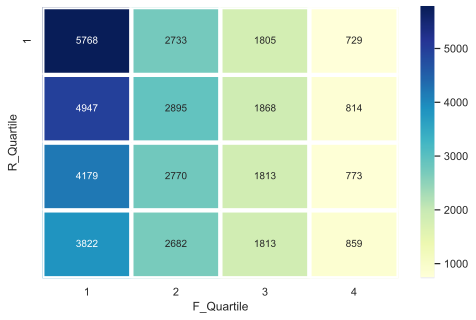

In [15]:
# строим heatmap по классам
rfm_table = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='monetary_value', 
                        aggfunc=np.median).applymap(int)
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4);

### Задания

In [16]:
# Какое максимальное кол-во покупок было совершено одним пользователем?
orders.groupby('CustomerCode')\
    .agg({'InvoiceNo':'count'})\
    .InvoiceNo.max()

204

In [17]:
# Сколько пользователей попало в сегмент 111 ?
rfmSegmentation[rfmSegmentation.RFMClass == '111'].shape[0]

9705

In [18]:
# В каком RFM-сегменте самое большое кол-во пользователей?
rfmSegmentation.groupby('RFMClass') \
               .agg({'recency': 'count'}) \
               .recency.idxmax()

'444'